In [501]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import differential_evolution   
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
import pandas as pd
import math 
from datetime import date
from scipy.integrate import solve_ivp
import sys
import os
import copy 
#!pip install lifelines
import seaborn as sns
import statistics
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats

In [462]:
# Reading data
df = pd.read_csv("Tumor_lengths.csv")
df = df.loc[~df['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # remove patients with too few data points
df_anyue = pd.read_excel("Individual parameters_START_TKI patients_AYin.xlsx")
df_anyue = df_anyue[["PID","PD_Kg(/day)","PD_Kd(/day)","PD_Km(/day)"]]
df_anyue = df_anyue.rename(columns={"PID": "ID", "PD_Kg(/day)": "kg", "PD_Kd(/day)": "kd", "PD_Km(/day)": "km"})
df_anyue = df_anyue.loc[~df_anyue['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # remove patients with too few data points
cols = df_anyue.columns.tolist()
cols[2],cols[3]=cols[3],cols[2] # swap kd and km so anyue's columns match ours
df_anyue = df_anyue[cols]

In [463]:
# Logistic population model
def system_ode_logistic(time, populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    kd = params[2] #death rate due to medication

    days = time

    dSpop_dt = Spop * (r * (1- (Spop + Rpop)/kmax) - kd)
    dRpop_dt = Rpop * (r * (1- (Spop + Rpop)/kmax))
    return [dSpop_dt, dRpop_dt]

# Cost function
def cost_func_logistic(params, time, data):
    # initial_populations = params[3:]
    initial_populations = [params[3], data[0]-params[3]]
    tspan = [days[0], days[-1]]
    
    pred_data_log = solve_ivp(system_ode_logistic, tspan, initial_populations, 
                             t_eval = np.ravel(days), args = tuple([params[:3]]))
    
    if pred_data_log.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data_log.y[0]
        rpop = pred_data_log.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        mean_abs_error = (np.sum(np.abs(sum_pops-data)))/len(data)
        #rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        #rmse = 1e30


    return msq_error


##### logistic with DE

In [465]:
from scipy.optimize import differential_evolution
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    max_value = max(data[0], data[-1])

    print("Working on patient:", id, " Number of data points:", len(days))
    #bounds = [(3e-2, 3e-1), (1.1*max_value, 2*max_value), (1e-2, 1e-1),(0, data[0]) # r, K, kd, spop, rpop
    bounds = [(5e-3, 3e-1), (1.1*max_value, 2*max_value), (1e-2, 1e-1),(0, data[0]-1e-3)] # r, K, kd, spop0, 


    # Use differential_evolution to perform a random search
    opt_result_log = differential_evolution(cost_func_logistic, bounds, args=(days, data))
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun]

Working on patient: A1002  Number of data points: 16
Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 6
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


In [466]:
df_log = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','kd','spop_0','mse'])
df_log

,r,Kmax,kd,spop_0,mse
A1002,0.023275,27706.303146,0.043577,13865.440830,1.213187e+06
A1004,0.005000,6613.340879,0.028915,5752.276266,1.789049e+03
A1006,0.005000,20440.846249,0.052603,17808.609359,1.435253e+05
A1007,0.005000,13942.281624,0.013600,10550.390644,5.925791e+05
A1008,0.005000,13437.867185,0.017241,11905.656879,5.765478e+05
A1009,0.012212,19865.730659,0.031249,16896.490793,3.968473e+05
A1011,0.005000,7793.226462,0.025639,3908.151306,2.306829e+03
A1012,0.005000,17607.365846,0.010000,14829.775872,3.733433e+06
A1013,0.005000,18911.512421,0.038541,16186.758900,2.768373e+05
A1014,0.005148,543.186171,0.030274,271.275025,2.418725e+02


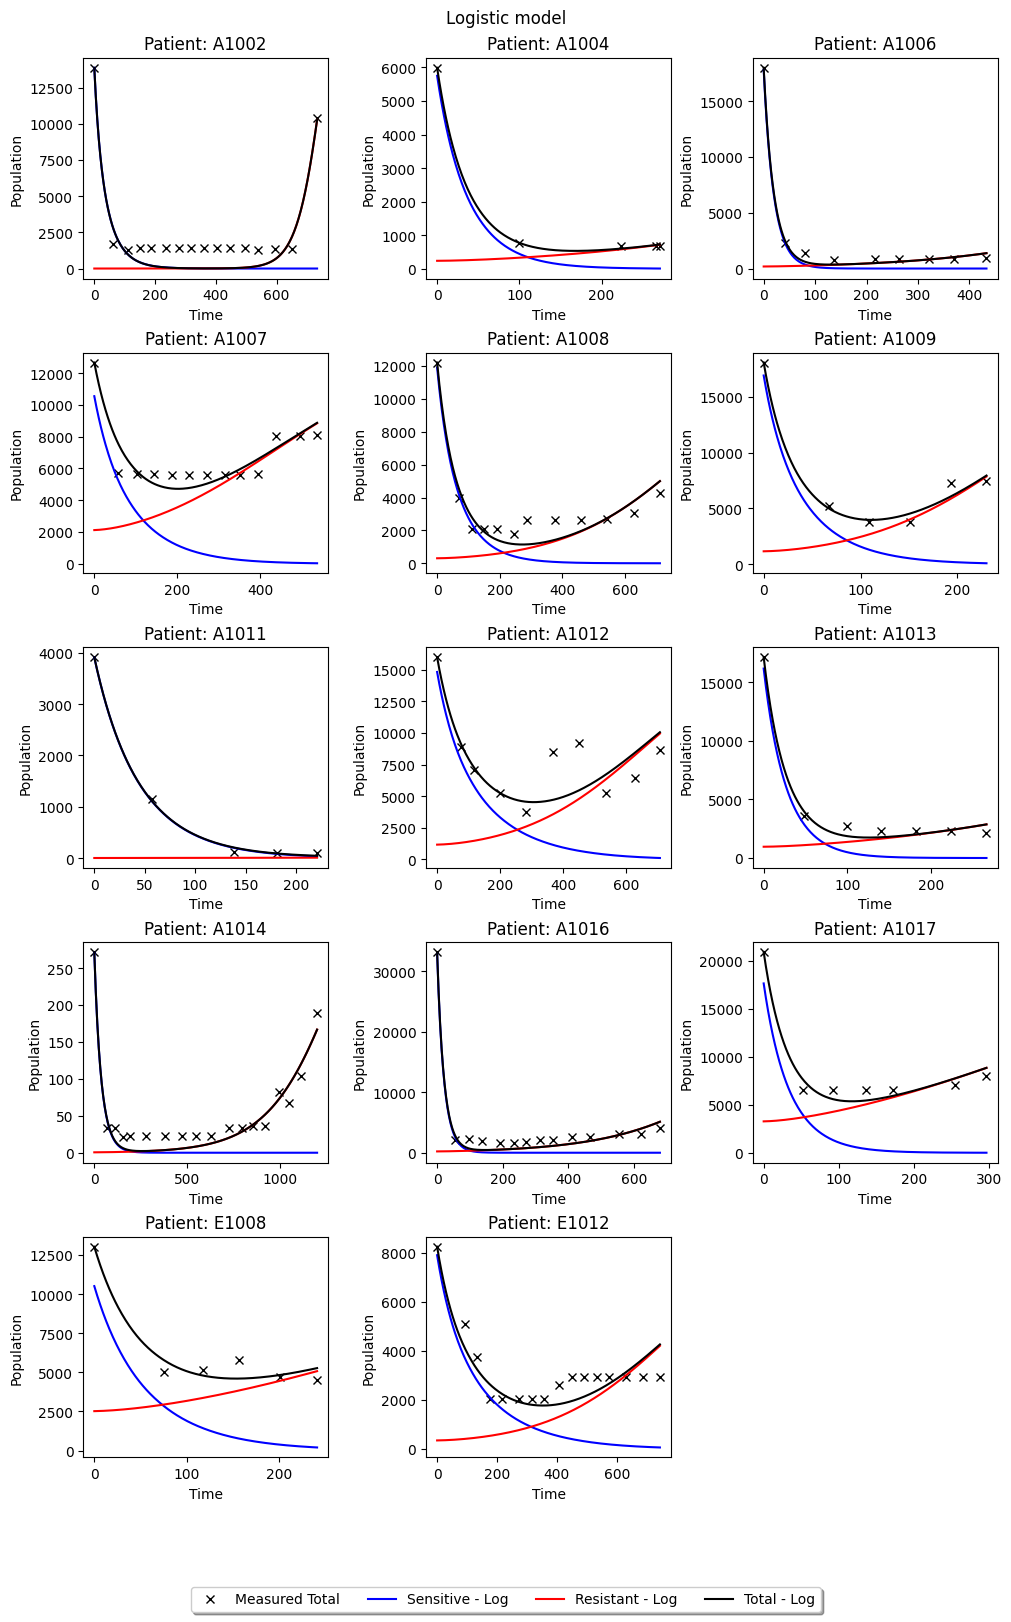

In [469]:
# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = master_dictionary[id]
    init_populations_log = [optimal_params_log[3], data[0]-optimal_params_log[3]]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model')  
plt.show()

##### Logistic DE MTD vs 1/2 MTD

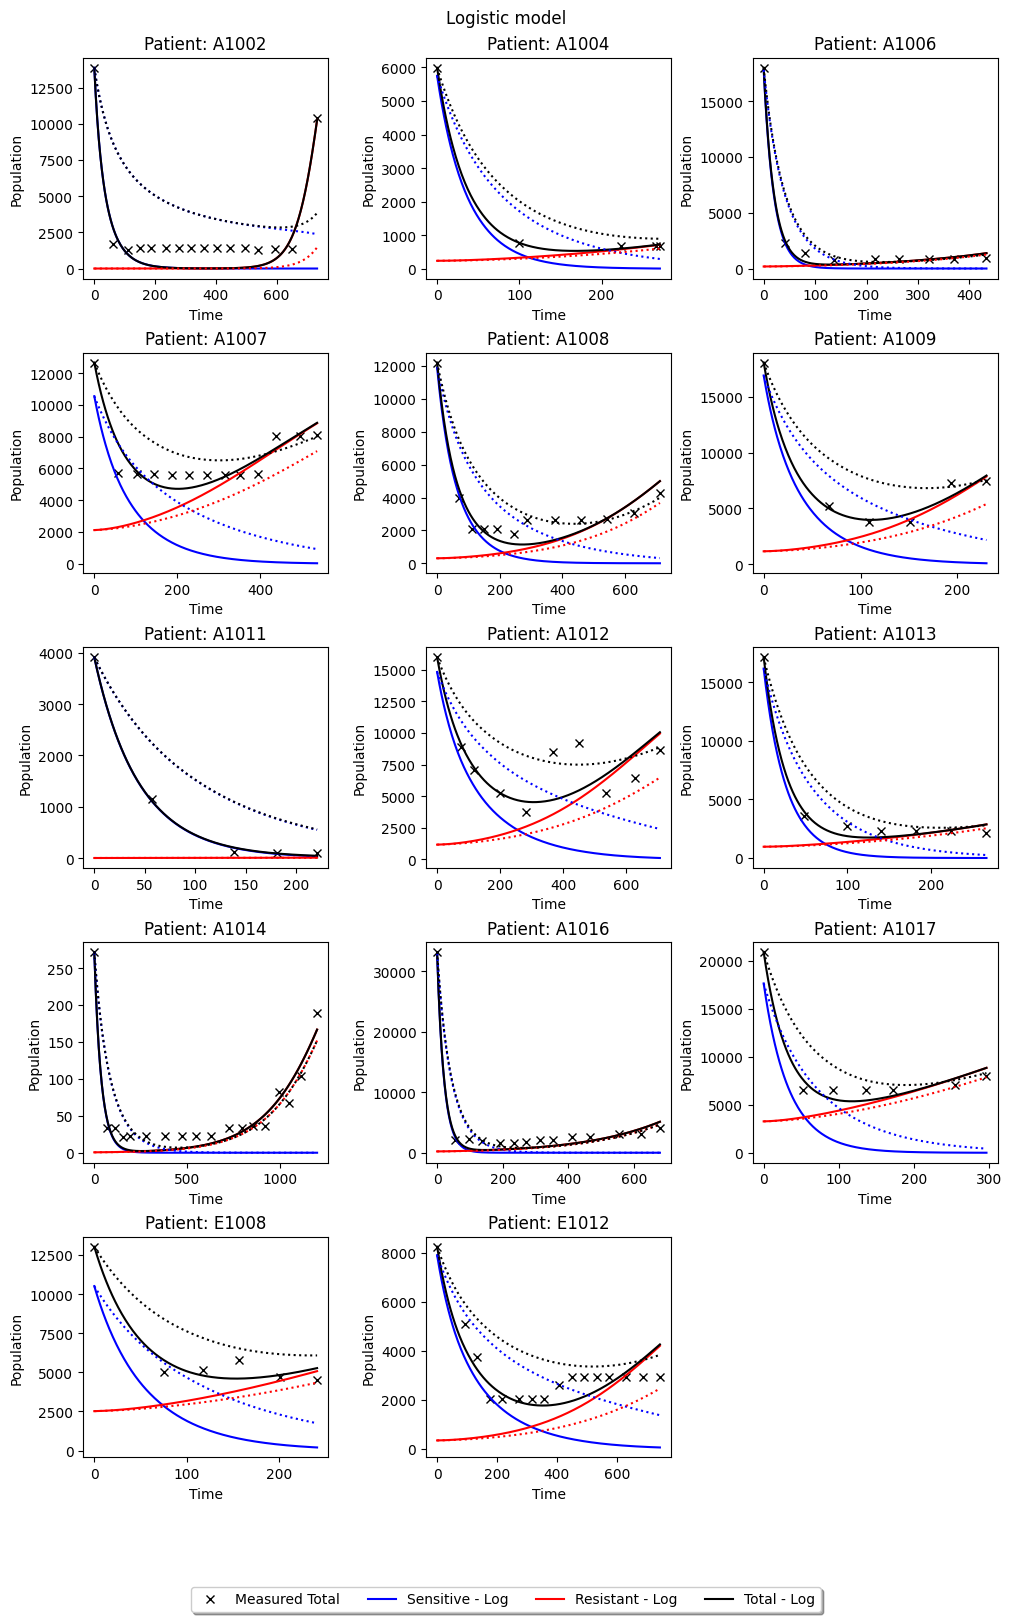

In [470]:
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = master_dictionary[id]
    init_populations_log = [optimal_params_log[3], data[0]-optimal_params_log[3]]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

# half dose
    optimal_params_half = master_dictionary_copy[id]
    init_populations_half = [optimal_params_half[3], data[0]-optimal_params_log[3]]

    pred_data_half = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_half, dense_output=True,
                            args = tuple([optimal_params_half[:3]]))
    sum_pops_half = np.sum(pred_data_half.sol(tspan), axis=0)



#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')

     # plot with half medication
    ax.plot(tspan, pred_data_half.sol(tspan)[0], 'b:', label='Sensitive 0.5*MTD') 
    ax.plot(tspan, pred_data_half.sol(tspan)[1], 'r:', label='Resistant 0.5*MTD') 
    ax.plot(tspan, sum_pops_half, 'k:', label='Total 0.5*MTD')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model')  
plt.show()

##### Extending time MTD vs 1/2 MTD logistic

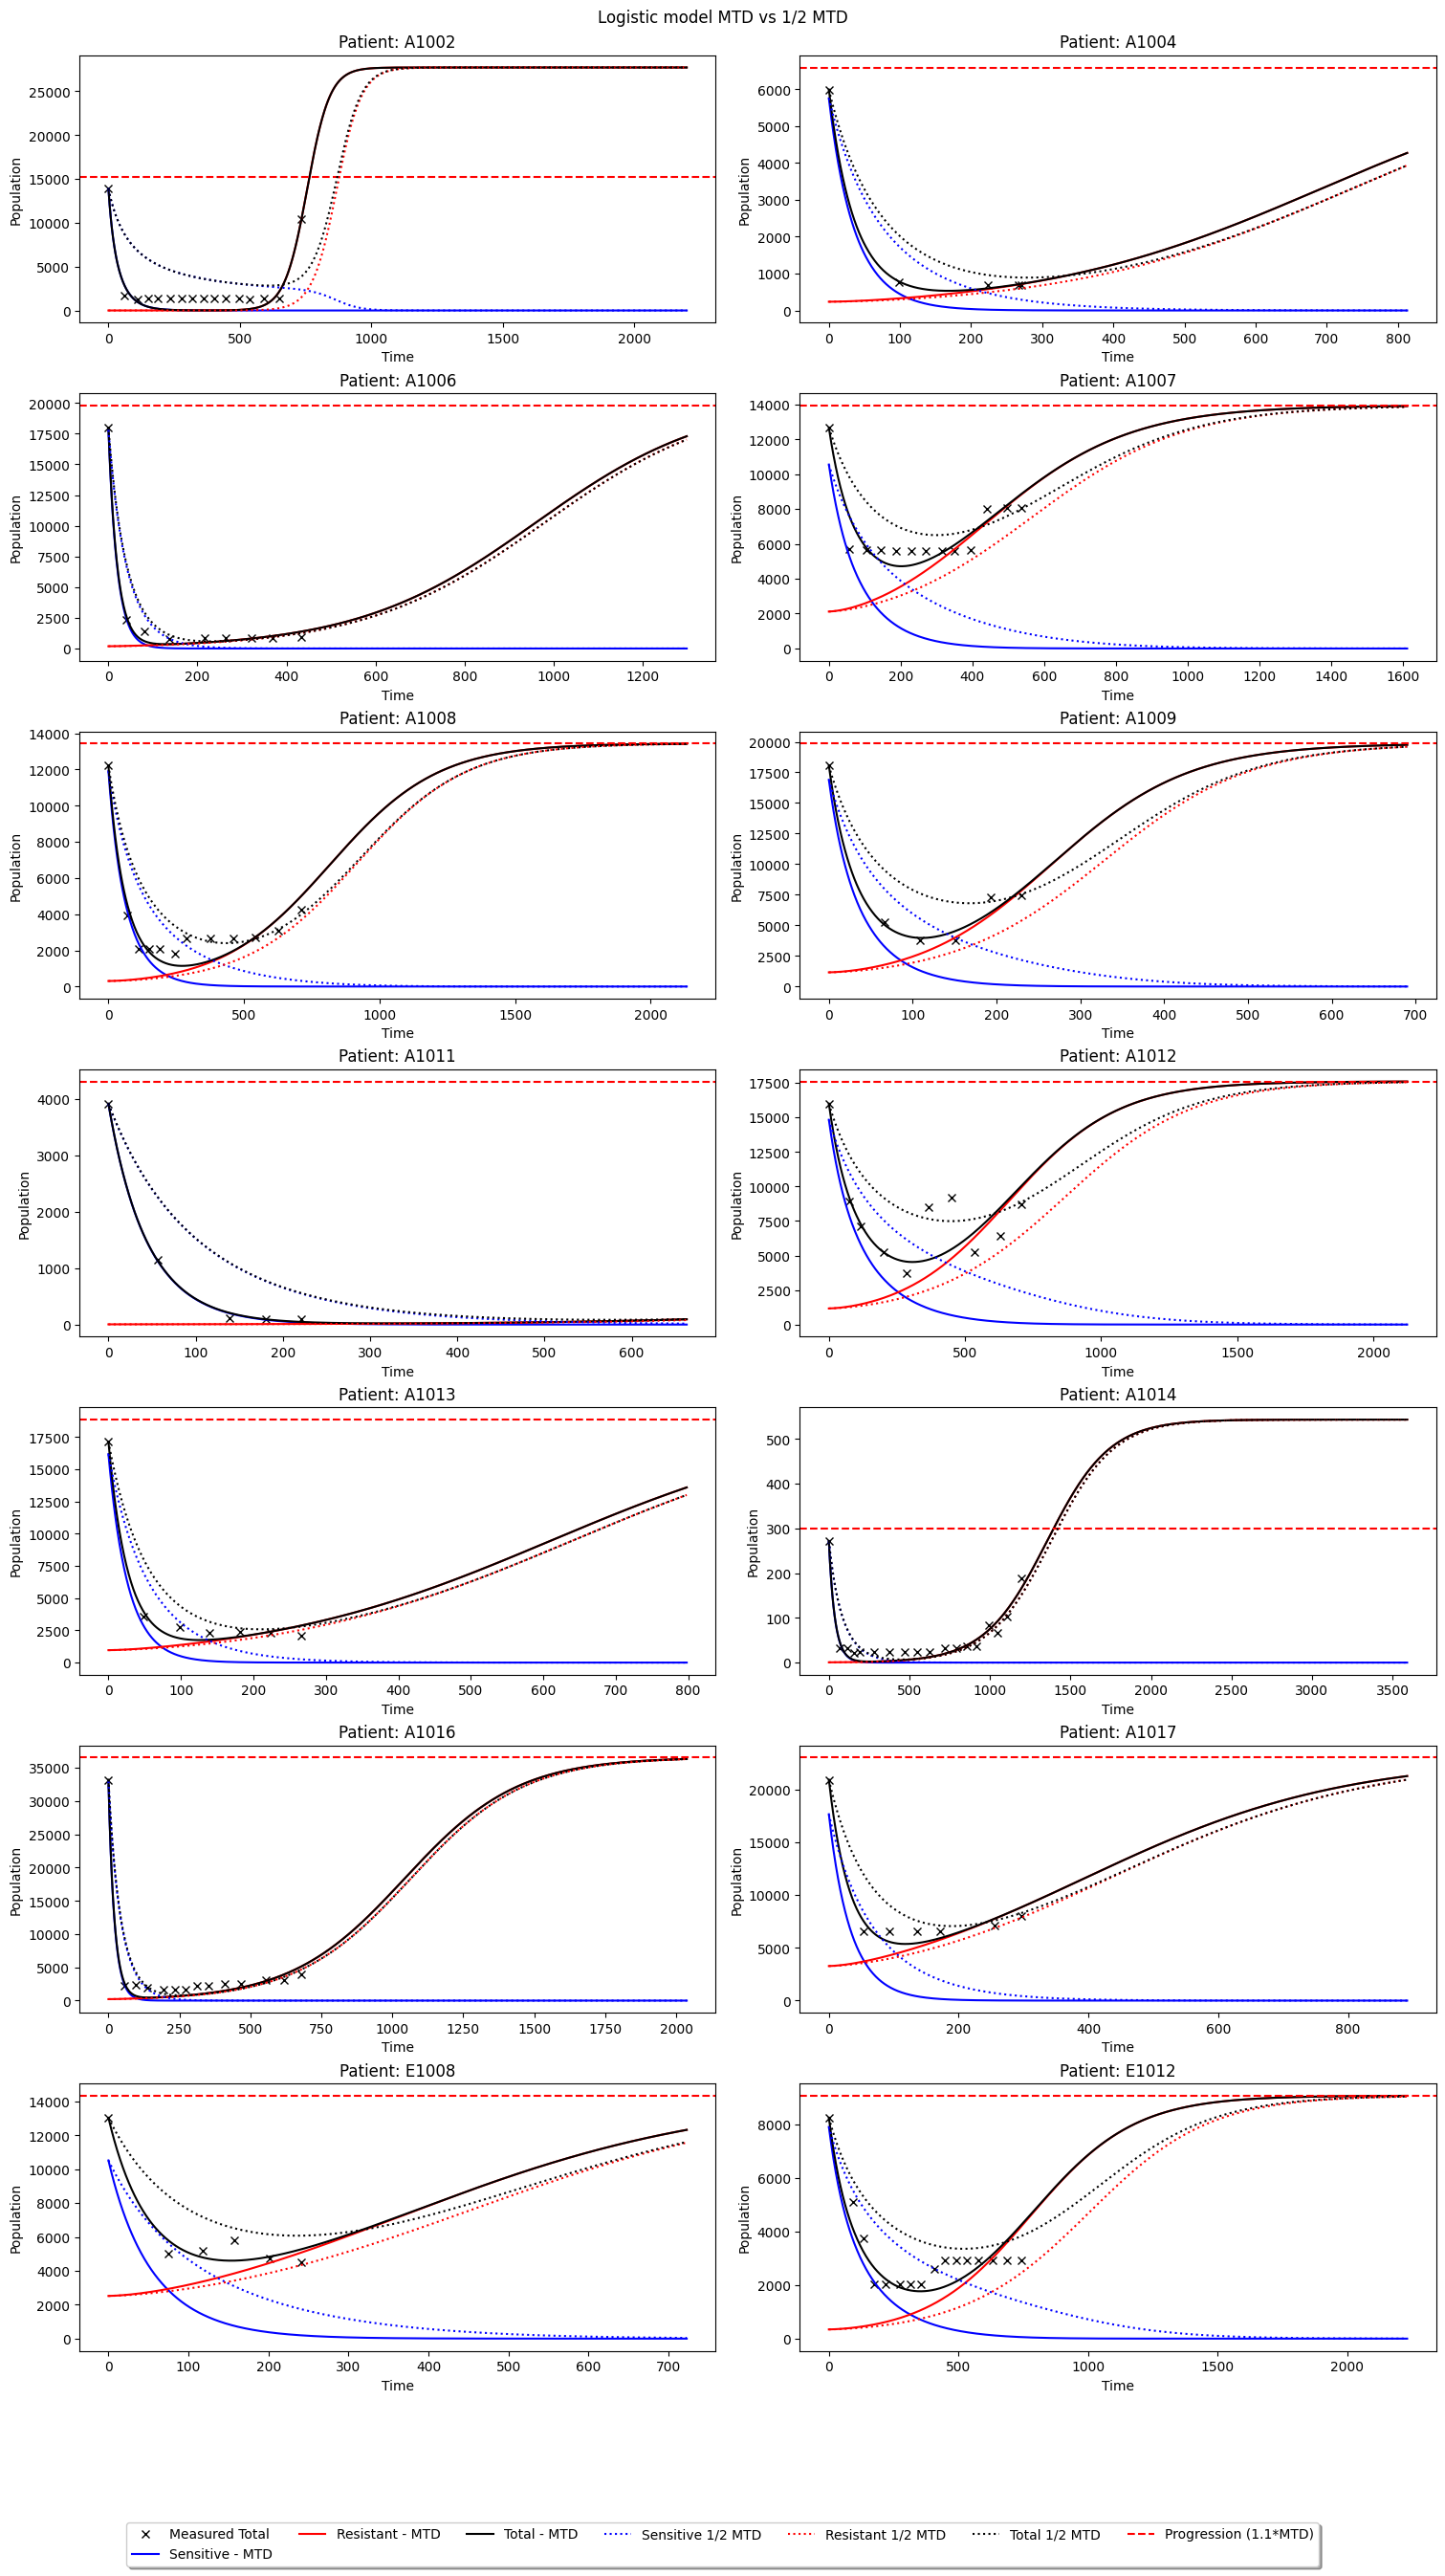

In [473]:
# Make a deep copy of master_dictionary to change medication parameters in

master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 25), constrained_layout=True)

# fitting data for parameters with half medication
for index, id in enumerate(unique_IDs, start=0):
    
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    sim_time_factor = 3

    tspan = np.linspace(0, sim_time_factor*days[-1], 1000)

    ### optimal params original medication 
    optimal_params_log = master_dictionary[id]
    init_populations_log = [optimal_params_log[3],data[0]-optimal_params_log[3]]
    pred_data_log = solve_ivp(system_ode_logistic, [0,sim_time_factor*days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)




### optimal params 1/2 medication
    optimal_params_log_half = master_dictionary_copy[id] 
    init_populations_log_half = [optimal_params_log_half[3],data[0]-optimal_params_log_half[3]]

    pred_data_log_half = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_log_half, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_log_half[:3]]))
    sum_pops_log_half = np.sum(pred_data_log_half.sol(tspan), axis=0)

    # Find progression for logistic MTD
    progression_mtd = np.argmin(np.abs(sum_pops_log - 1.1*data[0]))
    x_value_progression = tspan[progression_mtd]

    # Find progression for logistic half MTD
    progression_half_mtd = np.argmin(np.abs(sum_pops_log_half - 1.1*data[0]))
    x_value_progression_half = tspan[progression_half_mtd]

    # Append the id and x_value_progression to the list
    progression_list.append((id, x_value_progression))
    progression_half_list.append((id, x_value_progression_half))


#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    ax.plot(days, data, 'kx', label='Measured Total') 
    # plot with full medication
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.axhline(y=1.1*data[0], color='r', linestyle='--') ### line to show progression


    # plot with half medication
    ax.plot(tspan, pred_data_log_half.sol(tspan)[0], 'b:', label='Sensitive - Log') 
    ax.plot(tspan, pred_data_log_half.sol(tspan)[1], 'r:', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log_half, 'k:', label='Total - Log')

    #set axis labels
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - MTD'),
                   Line2D([0], [0], color='r', label='Resistant - MTD'),
                   Line2D([0], [0], color='k',label='Total - MTD'),
                   Line2D([0], [0], color='b', linestyle=':', label='Sensitive 1/2 MTD'),
                   Line2D([0], [0], color='r', linestyle=':', label='Resistant 1/2 MTD'),
                   Line2D([0], [0], color='k', linestyle= ':' ,label='Total 1/2 MTD'),
                   Line2D([0], [0], color='r', linestyle='--', label='Progression (1.1*MTD)')]


fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model MTD vs 1/2 MTD')  
plt.show()

##### TTP & competitive release

In [508]:
progression_list = []
progression_half_list = []
comp_release_list = []
comp_release_half_list = []


master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

for index, id in enumerate(unique_IDs, start=0):
    
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    sim_time_factor = 2
    tspan = np.linspace(0, sim_time_factor*days[-1], 1000)

### optimal params original medication 
    optimal_params_log = master_dictionary[id]
    init_populations_log = [optimal_params_log[3],data[0]-optimal_params_log[3]]
    pred_data_log = solve_ivp(system_ode_logistic, [0,sim_time_factor*days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

### optimal params 1/2 medication
    optimal_params_log_half = master_dictionary_copy[id] 
    init_populations_log_half = [optimal_params_log_half[3],data[0]-optimal_params_log_half[3]]

    pred_data_log_half = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_log_half, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_log_half[:3]]))
    sum_pops_log_half = np.sum(pred_data_log_half.sol(tspan), axis=0)

# Find progression for logistic MTD
    progression_mtd = np.argmin(np.abs(sum_pops_log - 1.1*data[0]))
    x_value_progression = tspan[progression_mtd]
    progression_list.append((id, x_value_progression))

# Find progression for logistic half MTD
    progression_half_mtd = np.argmin(np.abs(sum_pops_log_half - 1.1*data[0]))
    x_value_progression_half = tspan[progression_half_mtd]
    progression_half_list.append((id, x_value_progression_half))

# find time to competitive release MTD
    comp_rel_mtd = np.argmin(np.abs(pred_data_log.sol(tspan)[0]-pred_data_log.sol(tspan)[1]))
    x_val_cr_mtd = tspan[comp_rel_mtd]
    comp_release_list.append((id, x_val_cr_mtd))

# find time to competitive release half MTD
    comp_rel_half = np.argmin(np.abs(pred_data_log_half.sol(tspan)[0]-pred_data_log_half.sol(tspan)[1]))
    x_val_cr_half = tspan[comp_rel_half]
    comp_release_half_list.append((id, x_val_cr_half))
    

# collecting in data frames
df_progression = pd.DataFrame(progression_list, columns=['id', 'progression'])
df_progression_half = pd.DataFrame(progression_half_list, columns=['id', 'progression half MTD'])
df_cr_mtd = pd.DataFrame(comp_release_list, columns=['id', 'competitive release'])
df_cr_half = pd.DataFrame(comp_release_half_list, columns=['id', 'competitive release half MTD'])

# Merge the dataframes two at a time
df_temp = pd.merge(df_progression, df_progression_half, on='id')
df_temp2 = pd.merge(df_cr_mtd, df_cr_half, on='id')
# Merge the temporary dataframes
df_all_progressions = pd.merge(df_temp, df_temp2, on='id')
df_all_progressions.set_index('id', inplace=True)
# Create event columns
df_all_progressions['progression_event'] = df_all_progressions['progression'].apply(lambda x: 0 if x == 0 else 1)
df_all_progressions['progression_event_half'] = df_all_progressions['progression half MTD'].apply(lambda x: 0 if x == 0 else 1)
df_all_progressions['cr_event'] = df_all_progressions['competitive release'].apply(lambda x: 0 if x == 0 else 1)
df_all_progressions['cr_event_half'] = df_all_progressions['competitive release half MTD'].apply(lambda x: 0 if x == 0 else 1)

# Print the DataFrame
df_all_progressions

,progression,progression half MTD,competitive release,competitive release half MTD,progression_event,progression_event_half,cr_event,cr_event_half
id,,,,,,,,
A1002,764.550551,870.208208,377.139139,754.278278,1,1,1,1
A1004,0.000000,0.000000,110.136136,220.272272,0,0,1,1
A1006,0.000000,0.000000,86.686687,174.240240,0,0,1,1
A1007,1074.000000,1074.000000,118.258258,236.516517,1,1,1,1
A1008,1422.000000,1422.000000,213.513514,425.603604,1,1,1,1
A1009,460.000000,0.000000,85.645646,171.291291,1,0,1,1
A1011,0.000000,0.000000,270.332332,442.000000,0,0,1,1
A1012,1416.000000,1416.000000,255.135135,508.852853,1,1,1,1
A1013,0.000000,0.000000,73.489489,146.446446,0,0,1,1


##### Survival plots

median time to progression MTD: 1394.7027027027027
median time to progression 1/2 dose:  1416.0


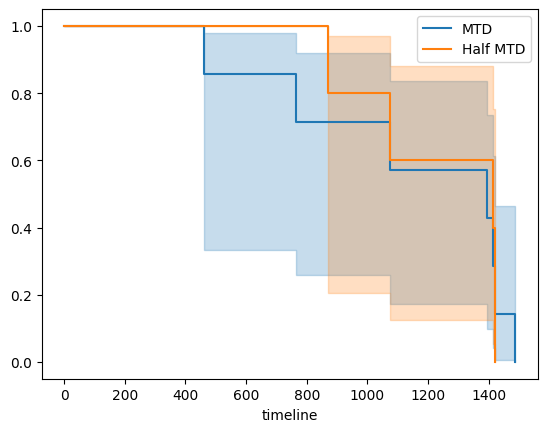

In [517]:
### survival plots for progression at 1.1*first data point 
Event1 = df_all_progressions["progression_event"]
Event2 = df_all_progressions["progression_event_half"]
kmf = KaplanMeierFitter()

# plot for MTD progression
kmf.fit(df_all_progressions["progression"],Event1, label='MTD')
ax = kmf.plot_survival_function()
print("median time to progression MTD:", kmf.median_survival_time_)
# plot for 1/2 MTD progression
kmf.fit(df_all_progressions["progression half MTD"], Event2, label='Half MTD')
ax = kmf.plot_survival_function(ax=ax)
print("median time to progression 1/2 dose: ",kmf.median_survival_time_)


median time to competitive release MTD: 255.13513513513513
median time to competitive release 1/2 dose:  508.8528528528529


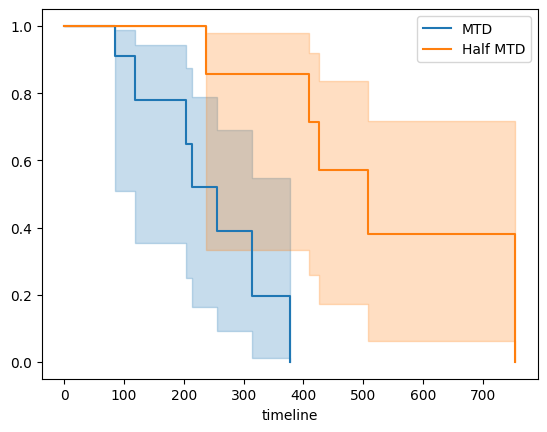

In [518]:
### survival plots for time to competitive release 
Event1 = df_all_progressions["progression_event"]
Event2 = df_all_progressions["progression_event_half"]
kmf = KaplanMeierFitter()

# plot for MTD progression
kmf.fit(df_all_progressions["competitive release"],Event1, label='MTD')
ax = kmf.plot_survival_function()
print("median time to competitive release MTD:", kmf.median_survival_time_)
# plot for 1/2 MTD progression
kmf.fit(df_all_progressions["competitive release half MTD"], Event2, label='Half MTD')
ax = kmf.plot_survival_function(ax=ax)
print("median time to competitive release 1/2 dose: ",kmf.median_survival_time_)
